In [13]:
# load packages
import os
import shutil
import csv
import requests
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from collections import defaultdict
import collections


# motivation
We want to check how many of the 153 target cities are actually covered by any in-situ data in our current vAirify database (29/07/2024). For this, we can quety our own backend API for a given time period (e.g. 1 day) and each city and analyse the response. The logic for querying and analysing the coverage is modularised to allow repeat analysis in the future. This might also be information whcih could be added to the web dashboard at some point in the future. It might also be worth to log the summary statistics to track any improvement/deterioration over time.

## get list of cities to check

In [14]:
# list of cities
csv_file_path = "data/CAMS_locations_v1.csv"

# API query parameters
end_date = datetime.now()
start_date = end_date - timedelta(days=1)

# plot directories
plot_directory = "figures/03"
# remove old plots
if os.path.exists(plot_directory):
    shutil.rmtree(plot_directory)
os.makedirs(plot_directory)


In [15]:
# get city information from CSV file
with open(csv_file_path, mode="r", newline="") as csvfile:
    reader = csv.DictReader(csvfile)
    city_rows = list(reader)

# create simple list of city names
cities = [city["city"] for city in city_rows]


## define helper functions

In [16]:
pollutants = ['pm2_5', 'pm10', 'o3', 'no2', 'so2']

def get_air_pollutant_measurements(cities, date_from, date_to, api_source="OpenAQ"):
    base_url = "http://64.225.143.231/api/air-pollutant/measurements"
    
    params = {
        'date_from': date_from,
        'date_to': date_to,
        'location_type': 'city',
        'location_names': cities,
        'api_source': api_source
    }
    
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        return response.json()
    

def count_measurements_by_city_and_pollutant(measurements):    
    # dictionary to store the count of measurements for each city and pollutant
    city_pollutant_counts = defaultdict(lambda: defaultdict(int))
    
    for measurement in measurements:
        city = measurement['location_name']
        for pollutant in pollutants:
            if pollutant in measurement:
                city_pollutant_counts[city][pollutant] += 1
                
    return city_pollutant_counts

def aggregate_measurements(measurements):
    total_measurements = defaultdict(int)
    for city, pollutants in measurements.items():
        for pollutant, count in pollutants.items():
            total_measurements[pollutant] += count
    return total_measurements

def calculate_city_coverage(measurements):
    total_cities = len(cities)
    pollutant_coverage = collections.defaultdict(int)

    for city_data in measurements.values():
        for pollutant in city_data:
            if city_data[pollutant] > 0:
                pollutant_coverage[pollutant] += 1

    # convert counts to percentages
    for pollutant in pollutant_coverage:
        pollutant_coverage[pollutant] = (pollutant_coverage[pollutant] / total_cities) * 100

    return pollutant_coverage

In [24]:
import matplotlib.pyplot as plt

def plot_measurements_and_coverage(total_measurements, city_coverage, start_date, end_date):
    """
    plots two horizontal bar charts: one for total measurements and one for city coverage,
    with opacity scaling and formatted titles.

    Parameters:
    - total_measurements (dict): Dictionary of pollutants and their total measurements.
    - city_coverage (dict): Dictionary of pollutants and the percentage of cities with measurements.
    - start_date (datetime): Start date for the time range.
    - end_date (datetime): End date for the time range.
    """

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    latex_labels = [r'PM$_{2.5}$', r'PM$_{10}$', r'O$_3$', r'NO$_2$', r'SO$_2$']

    # first bar chart (total measurements; extending to the left)
    counts = [total_measurements[pollutant] for pollutant in pollutants]
    bars1 = ax1.barh(pollutants[::-1], [-count for count in counts[::-1]], color='black')
    ax1.set_xlim(-max(counts) * 1.3, 0)
    ax1.set_title('                number of measurements', fontsize=24)

    # add annotations
    for bar in bars1:
        width = bar.get_width()
        ax1.text(width - 0.05 * max(counts), bar.get_y() + bar.get_height() / 2, 
                 f'{-width}', va='center', ha='right', color='black', fontsize=18)

    for spine in ax1.spines.values():
        spine.set_visible(False)
    ax1.xaxis.set_visible(False)
    ax1.yaxis.set_visible(False)


    # second bar chart (percentage of cities; extending to the right)
    coverage = [city_coverage[pollutant] for pollutant in pollutants]
    bars2 = ax2.barh(latex_labels[::-1], coverage[::-1], color='black')
    ax2.set_xlim(0, 100)
    ax2.set_title('cities covered (%)', fontsize=24, ha='right' )

    # add annotations
    for bar in bars2:
        width = bar.get_width()
        ax2.text(width + 2, bar.get_y() + bar.get_height() / 2, 
                 f'{width:.1f} %', va='center', ha='left', color='black', fontsize=18)

    for spine in ax2.spines.values():
        spine.set_visible(False)
    ax2.xaxis.set_visible(False)

    ax2.tick_params(axis='y', which='both', length=0, labelsize=30, pad=52)
    for tick in ax2.yaxis.get_majorticklabels():
        tick.set_horizontalalignment("center")

    # update alpha values based on coverage for both charts
    normalized_coverage = [c / 100 for c in coverage]
    for bar, alpha in zip(bars1, normalized_coverage[::-1]):
        bar.set_alpha(alpha)
    for bar, alpha in zip(bars2, normalized_coverage[::-1]):
        bar.set_alpha(alpha)
        

    # format the dates and hours
    start_date_str = f"{start_date.strftime('%d %B')} {start_date.hour}:00"
    end_date_str = f"{end_date.strftime('%d %B')} {end_date.hour}:00"
    fig.suptitle(f'vAirify in-situ coverage\n{start_date_str} to {end_date_str}', fontsize=30, ha='center', y=1.08)

    plt.savefig(
        f'{plot_directory}/vAirify_coverage_summary_bar_chart_{end_date.strftime("%Y-%m-%d")}.pdf',
        bbox_inches='tight'
    )
    plt.subplots_adjust(wspace=0.21)
    plt.show()


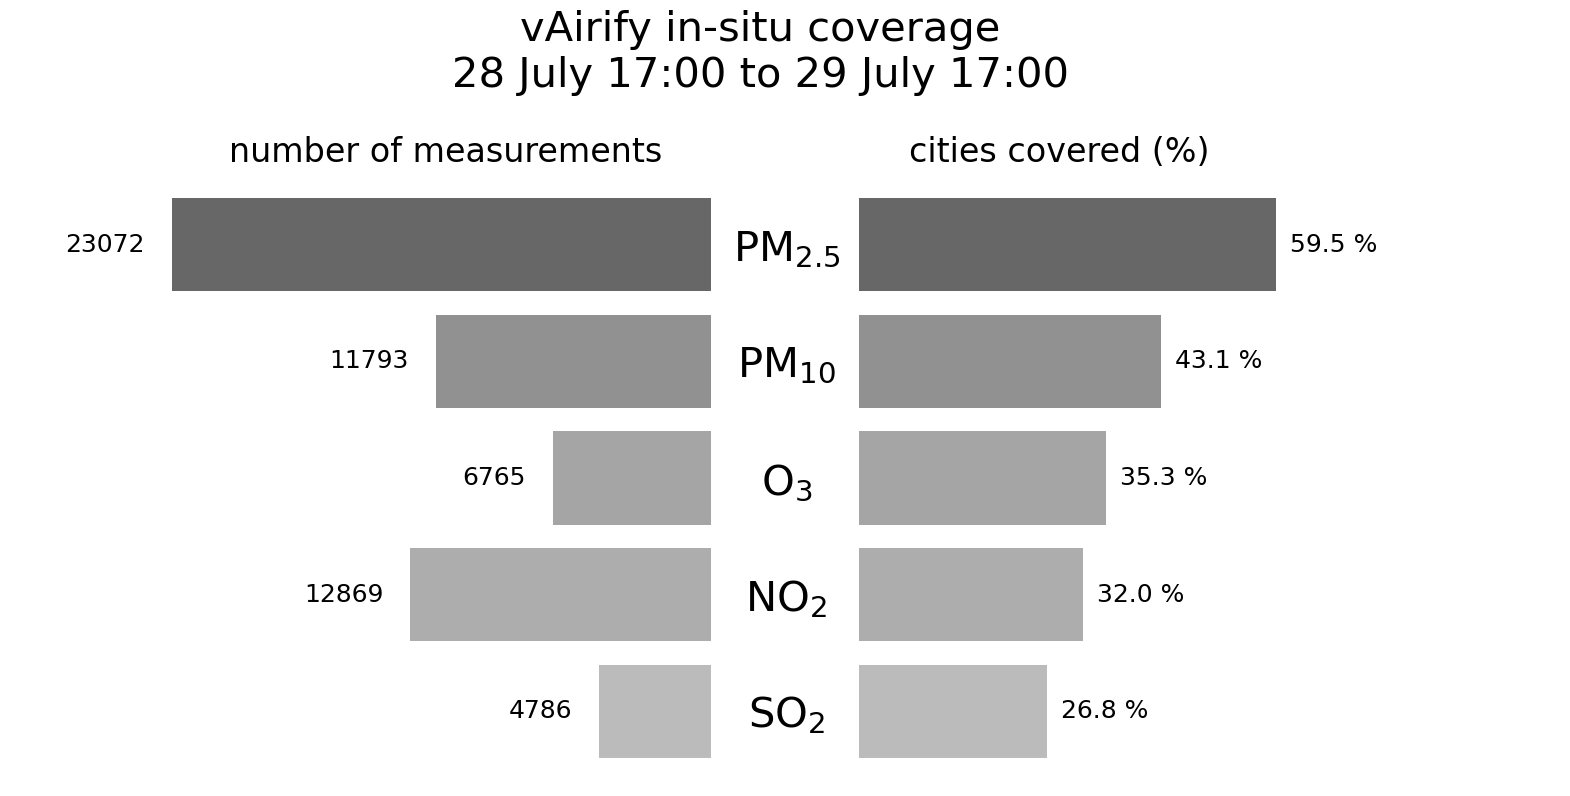

In [25]:
# fefine the analysis range
end_date = datetime.now()
start_date = end_date - timedelta(days=1)

# query vAirify API and process mesurements
results = get_air_pollutant_measurements(cities, start_date, end_date)
measurement_counts = count_measurements_by_city_and_pollutant(results)
total_measurements = aggregate_measurements(measurement_counts)
city_coverage = calculate_city_coverage(measurement_counts)

# call the plotting function
plot_measurements_and_coverage(total_measurements, city_coverage, start_date, end_date)


### overview maps of available data
let's add some maps for each pollutant to show for which cities we actually have data available

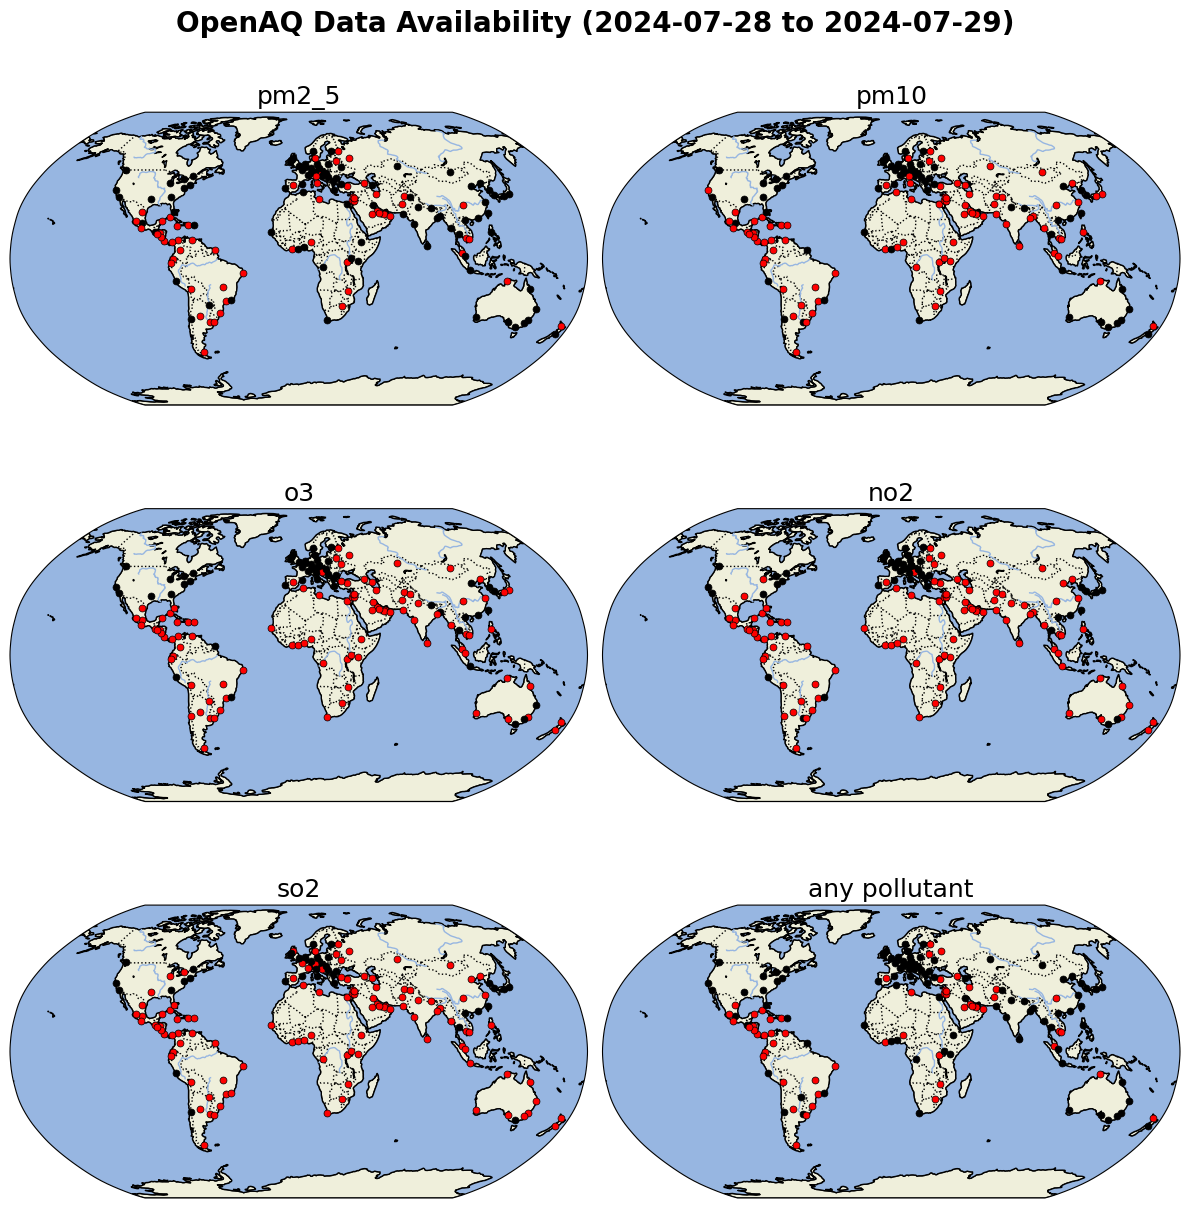

In [23]:
date_range_str = f'{start_date.strftime("%Y-%m-%d")} to {end_date.strftime("%Y-%m-%d")}'

# create global maps with cartopy
fig, axes = plt.subplots(
    nrows=3, ncols=2, figsize=(12, 13), subplot_kw={"projection": ccrs.Robinson()}
)
axes = axes.flatten()

available_color = "black"
not_available_color = "red"
edge_color = "black"

# one map for each pollutant
for i, parameter in enumerate(pollutants):
    ax = axes[i]
    ax.set_global()
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.add_feature(cfeature.LAND, edgecolor="black")
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.LAKES, edgecolor="black")
    ax.add_feature(cfeature.RIVERS)

    missing_locations = 0
    available_measurements = 0
    unique_stations = set()

    for row in city_rows:
        city_name = row["city"]
        latitude = float(row["latitude"])
        longitude = float(row["longitude"])
        if measurement_counts[city_name][parameter] > 0:
            ax.plot(
                longitude,
                latitude,
                marker="o",
                color=available_color,
                markersize=5,
                markeredgecolor=edge_color,
                markeredgewidth=0.5,
                transform=ccrs.PlateCarree(),
            )
        else:
            ax.plot(
                longitude,
                latitude,
                marker="o",
                color=not_available_color,
                markersize=5,
                markeredgecolor=edge_color,
                markeredgewidth=0.5,
                transform=ccrs.PlateCarree(),
            )

    ax.set_title(f"{pollutants[i]}", fontsize=18)


# additional subplot for availability of any pollutant
ax = axes[-1]
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.LAND, edgecolor="black")
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES, edgecolor="black")
ax.add_feature(cfeature.RIVERS)

for row in city_rows:
    city_name = row["city"]
    latitude = float(row["latitude"])
    longitude = float(row["longitude"])
    if any(value > 0 for value in measurement_counts[city_name].values()):
        ax.plot(
            longitude,
            latitude,
            marker="o",
            color=available_color,
            markersize=5,
            markeredgecolor=edge_color,
            markeredgewidth=0.5,
            transform=ccrs.PlateCarree(),
        )
    else:
        ax.plot(
            longitude,
            latitude,
            marker="o",
            color=not_available_color,
            markersize=5,
            markeredgecolor=edge_color,
            markeredgewidth=0.5,
            transform=ccrs.PlateCarree(),
        )
        missing_locations += 1

ax.set_title("any pollutant", fontsize=18)


fig.suptitle(
    f"OpenAQ Data Availability ({date_range_str})",
    fontsize=20,
    y=0.98,
    fontweight="bold",
)

plt.tight_layout()
plt.savefig(
    f'{plot_directory}/vAirify_coverage_global_maps_{end_date.strftime("%Y-%m-%d")}.pdf',
    bbox_inches='tight'
)
plt.show()

## regional breakdown

In [26]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_city_availability(city_rows, measurement_counts, date_range_str, plot_directory, end_date):
    # define continent boundaries
    continents = {
        'Africa': [-20, 50, -38, 40],
        'Asia': [35, 160, -15, 80],
        'Europe': [-30, 60, 35, 80],
        'North America': [-170, -50, 10, 85],
        'South America': [-90, -30, -58, 15],
        'Australia': [110, 160, -45, -5],
    }

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    axes = axes.flatten()  

    # plot each continent
    for ax, (continent, extent) in zip(axes, continents.items()):
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linestyle=":")
        ax.add_feature(cfeature.LAND, edgecolor="black")
        ax.add_feature(cfeature.OCEAN)
        ax.add_feature(cfeature.LAKES, edgecolor="black")
        ax.add_feature(cfeature.RIVERS)

        # plot cities
        missing_locations = 0
        for row in city_rows:
            city_name = row["city"]
            latitude = float(row["latitude"])
            longitude = float(row["longitude"])
            if any(value > 0 for value in measurement_counts.get(city_name, {}).values()):
                color = available_color
            else:
                color = not_available_color 
                missing_locations += 1
            
            ax.plot(
                longitude,
                latitude,
                marker="o",
                color=color,
                markersize=12,
                markeredgecolor='black',
                markeredgewidth=1.0,
                transform=ccrs.PlateCarree(),
            )
        ax.set_title(continent, fontsize=14)

    fig.suptitle(f"OpenAQ Data Availability ({date_range_str})", fontsize=20, fontweight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.95]) 

    plt.savefig(f'{plot_directory}/vAirify_coverage_regional_maps_{end_date.strftime("%Y-%m-%d")}.pdf', dpi=200)
    plt.show()


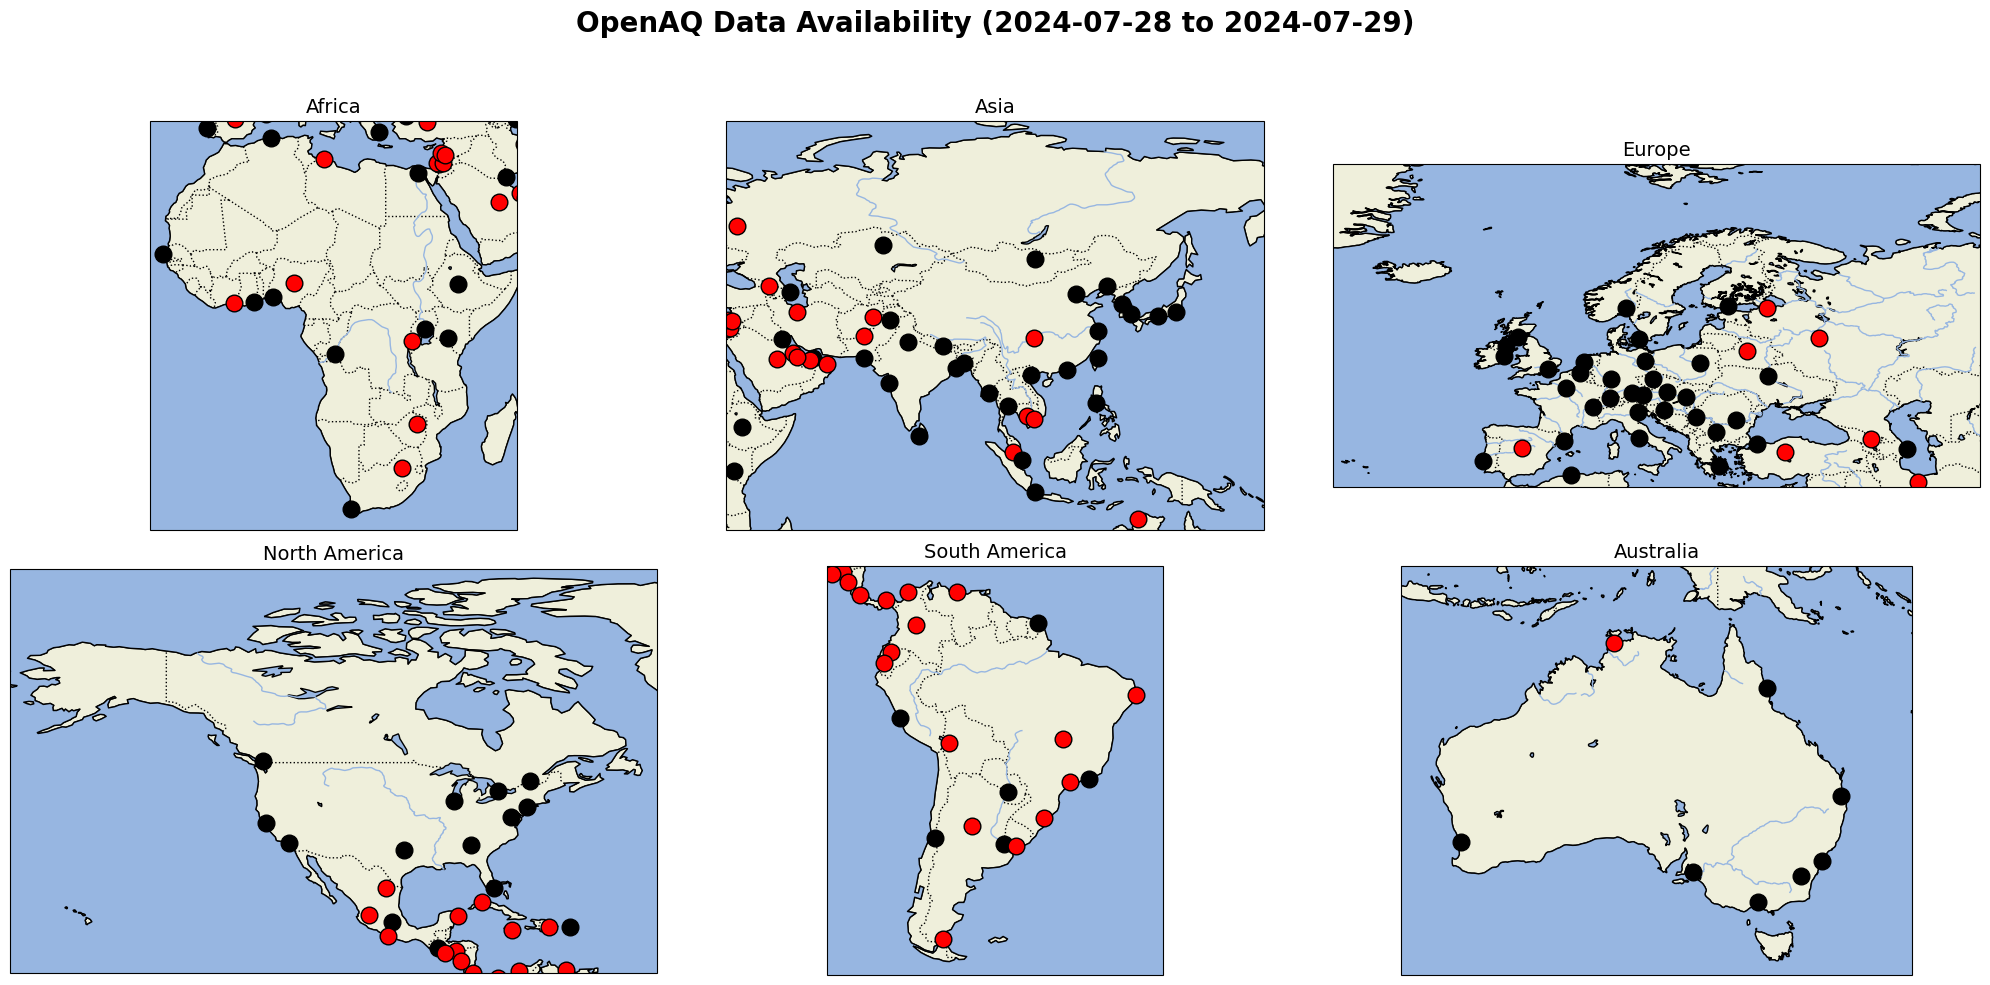

In [27]:
plot_city_availability(city_rows, measurement_counts, date_range_str, plot_directory, end_date)